## Exploring the wind energy functions
Welcome to a notebook that will help you gain a better understanding of the wind energy functions written for PlanIt! Let's get started.

In [115]:
import dateutil

import h5pyd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import wind_energy
import location_handling

-----------
This notebook explores the wind_energy.py module for PlanIt. First, let's load our dataset from the API.

In [5]:
f = h5pyd.File("/nrel/wtk-us.h5", 'r')

Lets use ``location_handling.get_loc`` to get the latitude and logitude of New York City. The output is a tuple of (lat, lon).

In [6]:
NYC = location_handling.get_loc('New York', 'NY')
NYC

(40.6943, -73.9249)

``location_handling.wtk_locator`` takes the latitutde and longitude of New York and finds the nearest latitude and longitude weather station within the NREL database. The index of this station in the dataset is outputted.

In [11]:
NYC_idx = location_handling.wtk_locator(f, NYC)
NYC_idx

(1044, 2378)

To access the wind data at 100 meters from this data station for the entire time period of the dataset (2007-2013), we use ``wind_energy.create_tseries``. The output is a list of numpy arrays. Each array contains a wind speed at every hour in a one year time slice. There are 7 time slices total.

In [96]:
tseries_list = wind_energy.create_tseries(f, NYC_idx)
tseries_list

[array([4.3153152, 5.157631 , 6.1098022, ..., 7.992798 , 5.8900757,
        6.3142776], dtype=float32),
 array([ 5.996887 ,  3.8911133,  3.4302826, ..., 10.739464 , 10.803551 ,
        15.704826 ], dtype=float32),
 array([16.165657 , 15.622421 , 15.451523 , ...,  1.4770966,  1.0803528,
         1.1322403], dtype=float32),
 array([1.4740448, 1.7151413, 2.4658966, ..., 4.333626 , 6.6316757,
        7.263405 ], dtype=float32),
 array([7.434311 , 7.821892 , 8.444473 , ..., 5.2888565, 7.721184 ,
        8.697777 ], dtype=float32),
 array([ 8.902252, 10.873749,  9.421066, ...,  8.798485, 10.205391,
        10.269478], dtype=float32),
 array([10.41597 ,  9.085358,  9.051788, ...,  6.579788, 12.097534,
         9.509567], dtype=float32)]

We will only be using one of the years (2008) of wind data as an example.

In [24]:
NYC08_tseries = wind_energy.create_tseries(f, NYC_idx)[1]
NYC08_tseries

array([ 5.996887 ,  3.8911133,  3.4302826, ..., 10.739464 , 10.803551 ,
       15.704826 ], dtype=float32)

Plotting the wind speed at 100 meters will help us gain a better understanding of what the data looks like. Wind data can most often be fit with a Weibull distribution. I have included references at the bottom of this notebook if you would like more information about fitting wind data.

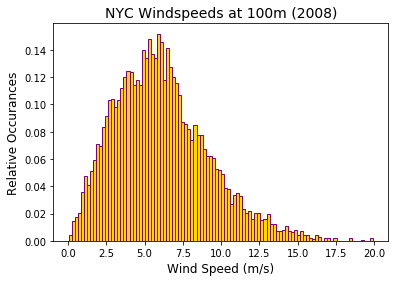

In [111]:
plt.hist(NYC08_tseries, bins = 100, density = True,
        color = 'gold', edgecolor='purple')
plt.ylabel('Relative Occurances', fontsize = 12)
plt.xlabel('Wind Speed (m/s)', fontsize = 12)
plt.title('NYC Windspeeds at 100m (2008)', fontsize=14)
plt.show()

------

#### ``power_eff``

The power efficiency of a turbine changes for different wind speeds. The function ``wind_energy.power_eff`` intakes a wind speed and outputs a power efficiency. The power efficiency vs wind speed curve is based on a curve from DOI: 10.1016/j.esd.2016.11.001.

In [127]:
# taking a random wind speed data point from the 2008 timeseries data
wind_speed = NYC08_tseries[100]
print('wind speed (m/s)', wind_speed)

wind speed (m/s) 5.996887


This example shows the power efficiency of a wind turbine at a wind speed of ~ 6 m/s.

In [126]:
Cp = wind_energy.power_eff(wind_speed)
Cp

0.40997799123981055

#### ``weibull_coeff``

Weibull distributions can be described by a shape (k) and scale (c) parameter. k describes the Weibull slope in a probability plot and c describes the height and width of the Weibull PDF. </p>
Here, we are computing the Weibull coefficients for the NYC 2008 wind data with the ``wind_energy.weibull_coeff`` function.

In [117]:
coeff = wind_energy.weibull_coeff(NYC08_tseries)
print('k:', coeff[0])
print('c:', coeff[1])

k: 2.095213510638354
c: 6.873579224294875


#### ``weibull_pdf``

The Weibull coefficients are then used to calculate the wind speed dependent Weibull probability function ``wind_energy.weibull_pdf``, given by:
</p>
$p(\nu)=\frac{k}{c}(\frac{\nu}{c})^{k-1}e^{-(\frac{\nu}{c})^{k}}$ </p>

-----
In this example, we are looking at the PDF output (specifically for the NYC 2008 wind speed data) for a windspeed of 4 m/s.

In [31]:
pdf = wind_energy.weibull_pdf(4.0, coeff[0], coeff[1])
pdf

0.12213775860325465

To make sure the sum of the PDFs for all windspeeds does not exceed 1, we compute the total probability of every windspeed.

In [121]:
tot_pdf=[]
for i in np.arange(NYC08_tseries.min(), NYC08_tseries.max(), 1):
    val = wind_energy.weibull_pdf(i, coeff[0], coeff[1])
    tot_pdf.append(val)
print(sum(tot_pdf))

0.9978093474549528


#### ``summation``

Next, we compute the average power over the entire range of windspeeds with the function ``wind_energy.summation``: </p>
$\sum_{0}^n C_p(\lambda) p(\nu) \nu^3 $

----
This function does not compute the power for windspeeds that are below 3.5 m/s or above 25 m/s. It also does not compute power above the nameplate capacity of the wind turbine.

-----
The output of the function is the sum of the powers at each windspeed in the range.

In [32]:
summation = wind_energy.summation(NYC08_tseries)
summation

132.1029434461051

#### ``wind_energy_output``

Lasty, AEO (Annual Energy Output) **per wind turbine**, is calculated by ``wind_energy.wind_energy_output``, which uses the AEO equation: $8760 * 0.5 \rho A *\sum_{0}^nC_p(\lambda) p(\nu) \nu^3$. The output is in Megawatt Hours (MWh).

-----
This example calculates the AEO for NYC in the year 2008

In [33]:
NYC08_energyoutput = wind_energy.wind_energy_output(NYC08_tseries)
NYC08_energyoutput

7439.234403990724

#### ``aeo_average``

This is the wrapping function for the wind energy functions. If we want to know the avearage AEO for all the years available in the WTK dataset **per wind turbine**, we simply need to run ``wind_energy.aeo_average``. The input is simply the wind tool kit dataframe and the NYC index from the dataframe. The output is in MWh.

In [34]:
NYC_tot_energyoutput = wind_energy.aeo_average(f, NYC_idx)
NYC_tot_energyoutput

7724.914938920573

#### ``wind_landuse``

For the government branch of the PlanIt app, we enable a user to input how much land available for renewable energy (in $km^2$). Based on this we can calculate the max energy output with ``wind_energy.wind_landuse``.

-----
In this example, a user has inputted 12 $km^2$. The output is in MWh.

In [35]:
wind_energy.wind_landuse(12, f, NYC_idx)

231747.4481676172

### A closer look at some of the data
A more indepth look at the power_eff function and the fit of a Weibull distribution to the data.

#### Import appropriate modules

In [114]:
from scipy.interpolate import CubicSpline
from reliability.Distributions import Weibull_Distribution

To make a power efficiency vs wind speed curve like the one in DOI: 10.1016/j.esd.2016.11.001, I took points from the curve and used the module ``CubicSpline`` to make a curve that followed those points.

In [42]:
x = list(np.arange(3, 26.0, 1))
y = [0.26, 0.35, 0.4, 0.41, 0.425, 0.445, 0.445, 0.425, 0.38, 0.335, 0.28,
         0.23, 0.19, 0.16, 0.13, 0.11, 0.09, 0.075, 0.065, 0.05, 0.04, 0.03,
         0.02]

The resulting curve looks like this:

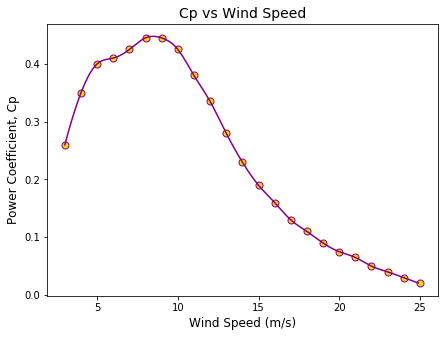

In [129]:
cs = CubicSpline(x, y)
xs = np.arange(3, 25.0, 0.1)

plt.figure(figsize=(7,5))
plt.plot(x,y, 'o', mfc='gold', mec = 'purple', ms = 7)
plt.plot(xs, cs(xs), color = 'purple')
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Power Coefficient, Cp', fontsize=12)
plt.title('Cp vs Wind Speed', fontsize=14)
plt.show()

A plot of the actual NYC 2008 wind speed data with a Weibull distribution, using parameters k and c from the fit of the data.

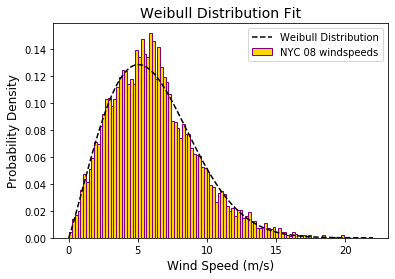

In [79]:
xvals = np.linspace(0, 22, 300)

plt.hist(NYC08_tseries, bins = 100, density = True,
         label = 'NYC 08 windspeeds', color = 'gold',
         edgecolor='purple')
Weibull_Distribution(alpha=coeff[1], beta=coeff[0]). \
                    PDF(xvals = xvals, label = 'Weibull Distribution', 
                        color = 'black', linestyle='--')
plt.title('Weibull Distribution Fit', fontsize = 14)
plt.ylabel('Probability Density', fontsize = 12)
plt.xlabel('Wind Speed (m/s)', fontsize = 12)
plt.legend()
plt.show()

----
----

### Extra information/background reading

Information on avg USA wind turbines (2018): https://www.energy.gov/sites/prod/files/2019/08/f65/2018%20Wind%20Technologies%20Market%20Report%20FINAL.pdf

#### Values used to calculate wind turbine power:
- nameplate capacity of newly installed wind turbines in the US in is 2.43 MW.
- average rotor diameter is 115.6 meters, average hub height is 88.1 meters.
--------
#### Wind turbines require:
- a minimum wind speed (3.5 m/s) to begin turning and generate electricity
- strong winds (~14 m/s) to generate at full capacity
- winds needs to be less than 25 m/s; beyond that speed, the turbines must be stopped to avoid damage
------
#### General resources:
- http://css.umich.edu/factsheets/wind-energy-factsheet
- https://www.raeng.org.uk/publications/other/23-wind-turbine
-----
#### Documentation:
- realiability module: https://reliability.readthedocs.io/en/latest/index.html
- basis for equation calculation : https://www.sciencedirect.com/science/article/pii/S0973082616308699
- kWh information/average values: 
    - https://www.windspire.ch/blog/2017/6/22/aep-part-1-capacity-and-more
    - https://www.windspire.ch/blog/2017/5/17/the-difference-between-kw-and-kwh-and-why-this-is-crucial-to-any-discussion-about-wind-energy
-----
#### Variables and units: 
- rho ($(\frac{kg}{m})^{3}$): air density
- A ($m^2$): area of the wind turbine blade
- $\nu$ ($\frac{m}{s}$): wind speed
- Cp (unitless): capacity factor (efficiency)
- p($\nu$) (unitless): Weibull distribution, include parameters k and c
-----
#### Equations:
- power $P_{avail} = 0.5 \rho A \nu^{3} C_{p}$
- Weibull PDF $p(\nu)=\frac{k}{c}(\frac{\nu}{c})^{k-1}e^{-(\frac{\nu}{c})^{k}}$
- Average power $\sum_{0}^n C_p(\lambda) p(\nu) \nu^3 $
- AEO (Annual Energy Output) = $8760 * 0.5 \rho A *\sum_{0}^nC_p(\lambda) p(\nu) \nu^3 $